In [1]:
IRdisplay::display_html(file='code_hiding.html')

Toggle ON/OFF 
code cells.

In [2]:
# USEFUL COMMAND!
# example(data.table)

In [1]:
# load packages and define constants
library(data.table) # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)
library(repr)
source("R_functions.r")

# folder/file-specific constants
PILOT_NUMBER <- 6
DATA_FOLDER <- "~/programing/data/psychophys/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# key-specific constants 
TRIALS <- "trials"
FRAMES <- "frames"
DOTS <- "dots"

# plot-specific constants
AXES_LABEL_FONT <- 18
AXES_FONT <- 15

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [2]:
# load csv files into data.tables
tb <- list(
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG))
names(tb) <- c(TRIALS, FRAMES, DOTS)

# add a trialCount column to the TRIALS and FRAMES table
tb[[TRIALS]][,trialCount:=.I]
tb[[FRAMES]] <- tb[[FRAMES]][tb[[TRIALS]][,.(trialCount, trialIndex)],on="trialIndex"]
# add all the fields from the TRIALS table to the DOTS table for Reverse Kernel analysis
tb[[DOTS]] <- tb[[DOTS]][tb[[TRIALS]],on="trialCount"]
str(tb[[DOTS]])

Classes ‘data.table’ and 'data.frame':	43862 obs. of  31 variables:
 $ xpos           : num  0.7459 0.5048 0.8971 0.3443 0.0796 ...
 $ ypos           : num  0.2885 0.8416 0.5606 0.5963 0.0589 ...
 $ isActive       : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent     : int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  6 6 6 6 6 6 6 6 6 6 ...
 $ trialStart     : num  805061 805061 805061 805061 805061 ...
 $ trialEnd       : num  805066 805066 805066 805066 805066 ...
 $ RT             : num  1.22 1.22 1.22 1.22 1.22 ...
 $ choice         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ correct        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ initDirection  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ endDirection   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ presenceCP     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ coherence      : num  25.6 25.6 25.6 25.6 25.6 25.6 25.6 25.6 25.6 25.6 ...
 $ v

# Notebook's goals

Make sure the workflow from running the task to analyzing the data works.

# A word on the data for this notebook
The tag for this data is `Pilot 6`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot6.mat).


# Workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot_#.mat` and upload it to PennBox (Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- Make sure data from the three `.csv` files is consistent

# Specific questions
1. How many frames are skipped on each trial, and where in the trial do they occur?
2. Does this number match the offset in viewing duration per trial?
3. Compute reverse kernels with the number of coherent dots as a proxy for motion energy

# Exploring the data
## The `*FIRA.csv` file (trials level)

In [3]:
# for this particular dataset, the timestamps of most columns have the wrong offset. This bug has been fixed since.
# for now, we still need to manually correct the time values as follows:
wideTimestamps <- tb[[TRIALS]][,.(trialStart=trialStart-trialStart,
                                       trialEnd=trialEnd-trialStart,
                                       dotsOn=dotsOn-2*trialStart,
                                       dotsOff=dotsOff-2*trialStart,
                                       targetOn=targetOn-2*trialStart,
                                       fixationOn=fixationOn - 2*trialStart,
                                       choiceTime=choiceTime-2*trialStart,
                                       trialCount),by=trialIndex]
str(tb[[TRIALS]])

Classes ‘data.table’ and 'data.frame':	18 obs. of  26 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  6 9 12 14 1 15 4 17 11 10 ...
 $ trialStart     : num  805061 805066 805071 805076 805081 ...
 $ trialEnd       : num  805066 805071 805076 805081 805085 ...
 $ RT             : num  1.222 1.223 1.1 0.703 1.228 ...
 $ choice         : int  1 0 0 0 0 1 0 1 1 0 ...
 $ correct        : int  1 0 0 1 1 0 1 1 1 0 ...
 $ initDirection  : int  0 0 0 0 180 180 180 180 0 0 ...
 $ endDirection   : int  0 0 0 180 180 180 180 0 0 0 ...
 $ presenceCP     : int  0 0 0 1 0 0 0 1 0 0 ...
 $ coherence      : num  25.6 12.8 25.6 6.4 6.4 12.8 12.8 25.6 25.6 12.8 ...
 $ viewingDuration: num  0.1 0.2 0.2 0.3 0.1 0.3 0.1 0.3 0.2 0.2 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  7597 9958 1108 5553 2607 9306 2457 859 8670 7918 ...
 $ fixationOn     : num

A deeper look at the timestamps fields

In [4]:
refTime <- wideTimestamps[,.(trialCount,
    refTime=min(trialStart, trialEnd, dotsOn, dotsOff, targetOn, choiceTime),
    trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
                        by=trialIndex]
longTimestamps <- melt(refTime,
                       id.vars=c("trialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
str(longTimestamps)

Classes ‘data.table’ and 'data.frame':	126 obs. of  3 variables:
 $ trialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Event     : Factor w/ 7 levels "trialStart","fixationOn",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ timestamp : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


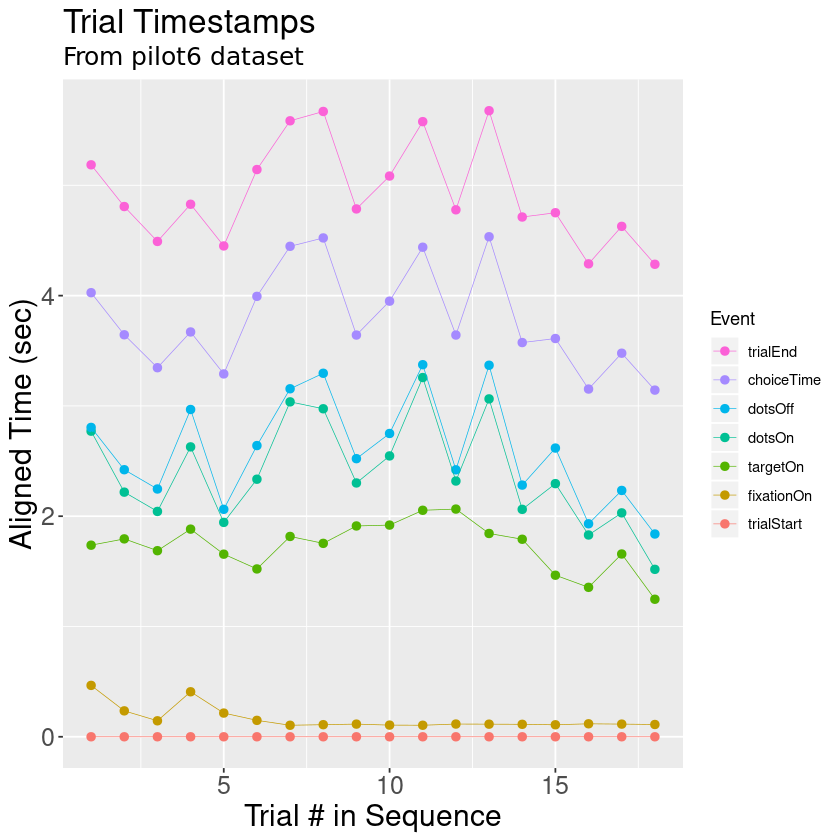

In [7]:
# plot
ggplot(longTimestamps, aes(x=trialCount, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)",
         x="Trial # in Sequence") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## The `*framesInfo.csv` file (frames level)

In [8]:
str(tb[[FRAMES]])

Classes ‘data.table’ and 'data.frame':	314 obs. of  7 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  805062 805063 805064 805064 805064 ...
 $ onsetFrame   : int  215 290 345 351 352 353 508 600 624 625 ...
 $ swapTime     : num  805062 805063 805064 805064 805064 ...
 $ isTight      : int  0 0 0 0 1 1 0 0 0 1 ...
 $ trialIndex   : int  6 6 6 6 6 6 9 9 9 9 ...
 $ trialCount   : int  1 1 1 1 1 1 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## The `*dotsPositions.csv` file (dots level)

In [9]:
str(tb[[DOTS]])
#tb[[DOTS]][,.(.N),by=.(frameIdx,trialCount)]

Classes ‘data.table’ and 'data.frame':	43862 obs. of  31 variables:
 $ xpos           : num  0.7459 0.5048 0.8971 0.3443 0.0796 ...
 $ ypos           : num  0.2885 0.8416 0.5606 0.5963 0.0589 ...
 $ isActive       : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent     : int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  6 6 6 6 6 6 6 6 6 6 ...
 $ trialStart     : num  805061 805061 805061 805061 805061 ...
 $ trialEnd       : num  805066 805066 805066 805066 805066 ...
 $ RT             : num  1.22 1.22 1.22 1.22 1.22 ...
 $ choice         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ correct        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ initDirection  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ endDirection   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ presenceCP     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ coherence      : num  25.6 25.6 25.6 25.6 25.6 25.6 25.6 25.6 25.6 25.6 ...
 $ v

# Checking that the three datasets are consistent
As we can see, the `frameIdx` field is common to `tb[[FRAMES]]` and `tb[[DOTS]]`, and the `trialIdx` is common to `tb[[DOTS]]` and `tb[[TRIALS]]`. Let's check whether these common fields match in terms of their unique values in each dataset.

## Exploring match between `DOTS` and `TRIALS` levels

## Exploring match between `FRAMES` and `TRIALS` levels
### Timing of trial vs. timing of frames

In [19]:
# add (bug-corrected) dotsOn, dotsOff values to filter swapTimes
# add trialStart for future offset
# the syntax is that of a right join
frameTimes <- tb[[FRAMES]][tb[[TRIALS]][,.(trialStart, 
                                           dotsOn=dotsOn-trialStart, 
                                           dotsOff=dotsOff-trialStart, 
                                           trialIndex)], on="trialIndex"]

# only consider frames with swapTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime>=dotsOn & onsetTime <= dotsOff]
str(frameTimes)

Classes ‘data.table’ and 'data.frame':	240 obs. of  10 variables:
 $ frameTotCount: int  69 70 71 72 73 74 75 265 266 267 ...
 $ onsetTime    : num  805083 805083 805083 805083 805083 ...
 $ onsetFrame   : int  1444 1445 1446 1447 1448 1449 1450 4756 4757 4757 ...
 $ swapTime     : num  805083 805083 805083 805083 805083 ...
 $ isTight      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex   : int  1 1 1 1 1 1 1 2 2 2 ...
 $ trialCount   : int  5 5 5 5 5 5 5 16 16 16 ...
 $ trialStart   : num  805081 805081 805081 805081 805081 ...
 $ dotsOn       : num  805083 805083 805083 805083 805083 ...
 $ dotsOff      : num  805083 805083 805083 805083 805083 ...
 - attr(*, ".internal.selfref")=<externalptr> 


- does the "number of frames" match across the three files?

In [22]:
setkey(frameTimes, trialIndex)
setkey(tb[[TRIALS]], trialIndex)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
frameCount <- merge(
    tb[[TRIALS]][,.(numInTRIALS=numFrames, trialCount),by=trialIndex],
    frameTimes[,.(numInFRAMES=.N),by=trialIndex],
    all=TRUE)

str(frameCount)

Classes ‘data.table’ and 'data.frame':	18 obs. of  4 variables:
 $ trialIndex : int  1 2 3 4 5 6 7 8 9 10 ...
 $ numInTRIALS: int  11 11 11 11 12 6 18 19 17 17 ...
 $ trialCount : int  5 16 11 7 12 1 17 14 2 10 ...
 $ numInFRAMES: int  7 7 7 7 8 2 13 15 13 13 ...
 - attr(*, "sorted")= chr "trialIndex"
 - attr(*, ".internal.selfref")=<externalptr> 


In [23]:
frameCount[tb[[DOTS]][order(trialIndex),.(numInDOTS=max(frameIdx)),by=trialIndex],on="trialIndex"]

trialIndex,numInTRIALS,trialCount,numInFRAMES,numInDOTS
1,11,5,7,7
2,11,16,7,7
3,11,11,7,7
4,11,7,7,7
5,12,12,8,8
6,6,1,2,2
7,18,17,13,14
8,19,14,15,15
9,17,2,13,13
10,17,10,13,13


From the columns above, we see that:
- the `numFrames` field from the `tb[[TRIALS]]` table is not useful
- I should match dots and frames using timestamps

- what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [24]:
# get times of first and last frame in each trial, align everything to dotsOn
extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime)-dotsOn, 
                                   lastFrame=max(onsetTime)-dotsOn,
                                   trialStart=trialStart-dotsOn, 
                                   dotsOn=dotsOn-dotsOn, 
                                   dotsOff=dotsOff-dotsOn,
                                   trialCount),
                                  by=trialIndex]
str(extremeFrameTimes)

Classes ‘data.table’ and 'data.frame':	240 obs. of  7 variables:
 $ trialIndex: int  1 1 1 1 1 1 1 2 2 2 ...
 $ firstFrame: num  0.000958 0.000958 0.000958 0.000958 0.000958 ...
 $ lastFrame : num  0.103 0.103 0.103 0.103 0.103 ...
 $ trialStart: num  -1.94 -1.94 -1.94 -1.94 -1.94 ...
 $ dotsOn    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ dotsOff   : num  0.119 0.119 0.119 0.119 0.119 ...
 $ trialCount: int  5 5 5 5 5 5 5 16 16 16 ...
 - attr(*, "sorted")= chr "trialIndex"
 - attr(*, ".internal.selfref")=<externalptr> 


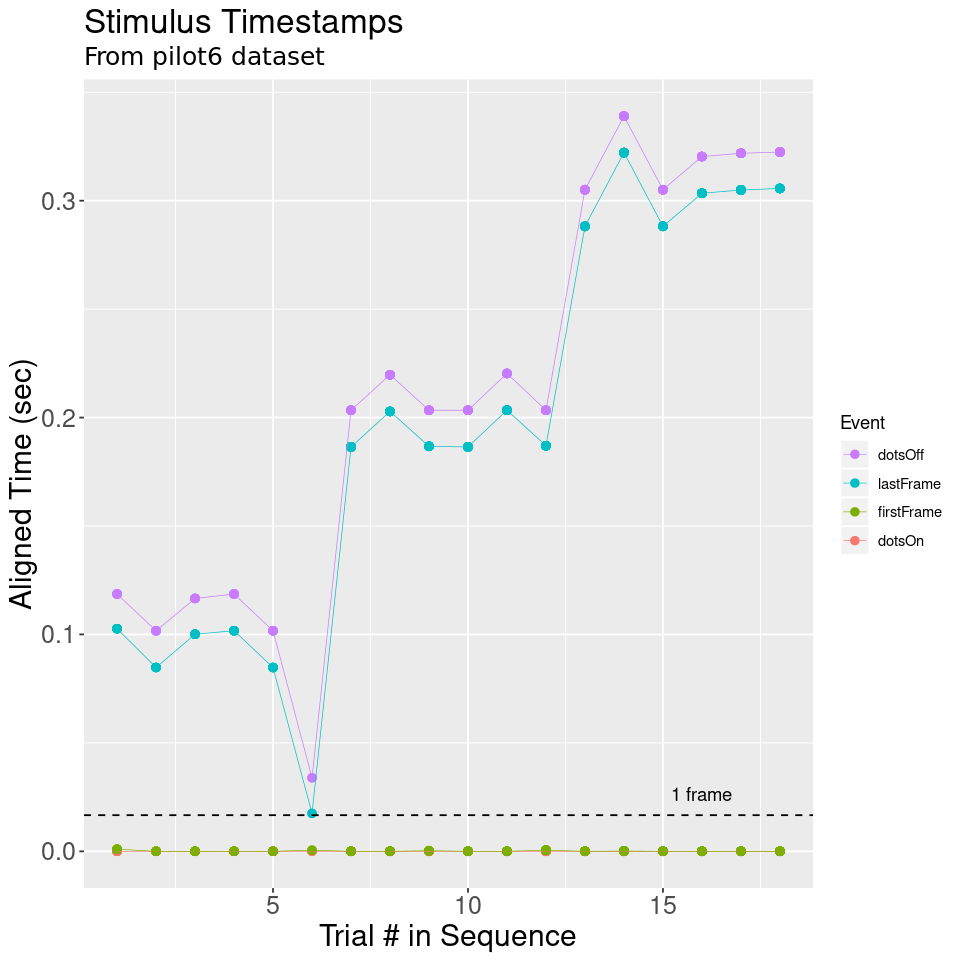

In [33]:
# transform to long format for ggplot 
longTimeData <- melt(extremeFrameTimes, 
                    id.vars=c("trialIndex"),
                    measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
                    variable.name="Event", value.name="timestamp")
#str(longTimeData)


frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longTimeData, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
   geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
   annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
   guides(colour = guide_legend(reverse=T)) +
   labs(title="Stimulus Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)",
         x="Trial # in Sequence") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- Exploration of `Tight` frames in each trial

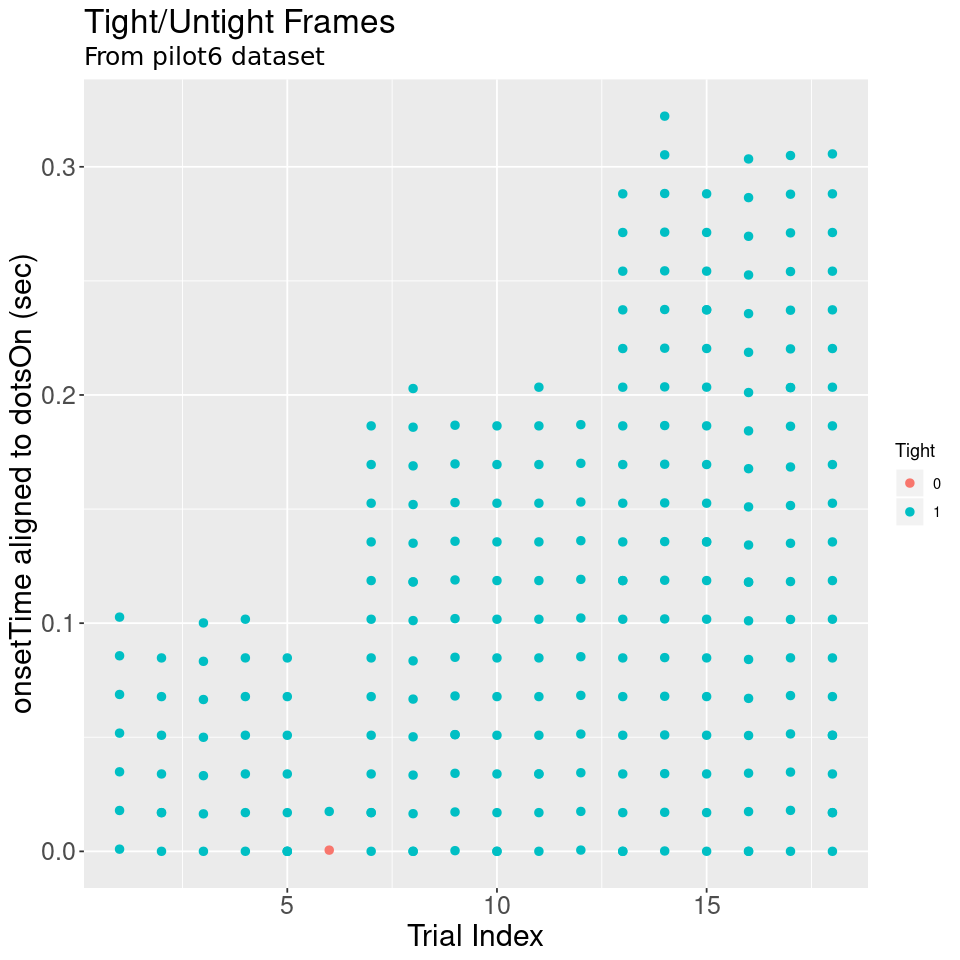

In [35]:
# plot
ggplot(frameTimes, aes(x=trialIndex, y=onsetTime-dotsOn)) + geom_point(aes(col=factor(isTight)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
#    guides(colour = guide_legend(reverse=T)) +
   labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
         x="Trial Index",
        color="Tight") + 
   theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## Exploring match between `FRAMES` and `DOTS`

In [16]:
# unique(tb[[DOTS]][,frameIdx])
# tb[[DOTS]][order(trialIndex),.(frameIdx), by=.(trialIndex, frameIdx)]

# Reverse Kernel Analysis

Let's display the number of coherent dots on each frames, grouping by subject's choice.

In [17]:
# count coherent dots on each frame
cohDots <- tb[[DOTS]][,.(numCohDots=sum(isCoherent)),by=.(trialCount,frameIdx)]
str(cohDots)
# let's try to sign numCohDots according to the direction of motion (+ for R and - for L)


Classes ‘data.table’ and 'data.frame':	241 obs. of  3 variables:
 $ trialCount: int  1 1 2 2 2 2 2 2 2 2 ...
 $ frameIdx  : int  1 2 1 2 3 4 5 6 7 8 ...
 $ numCohDots: int  20 15 9 11 14 9 10 11 12 14 ...
 - attr(*, ".internal.selfref")=<externalptr> 


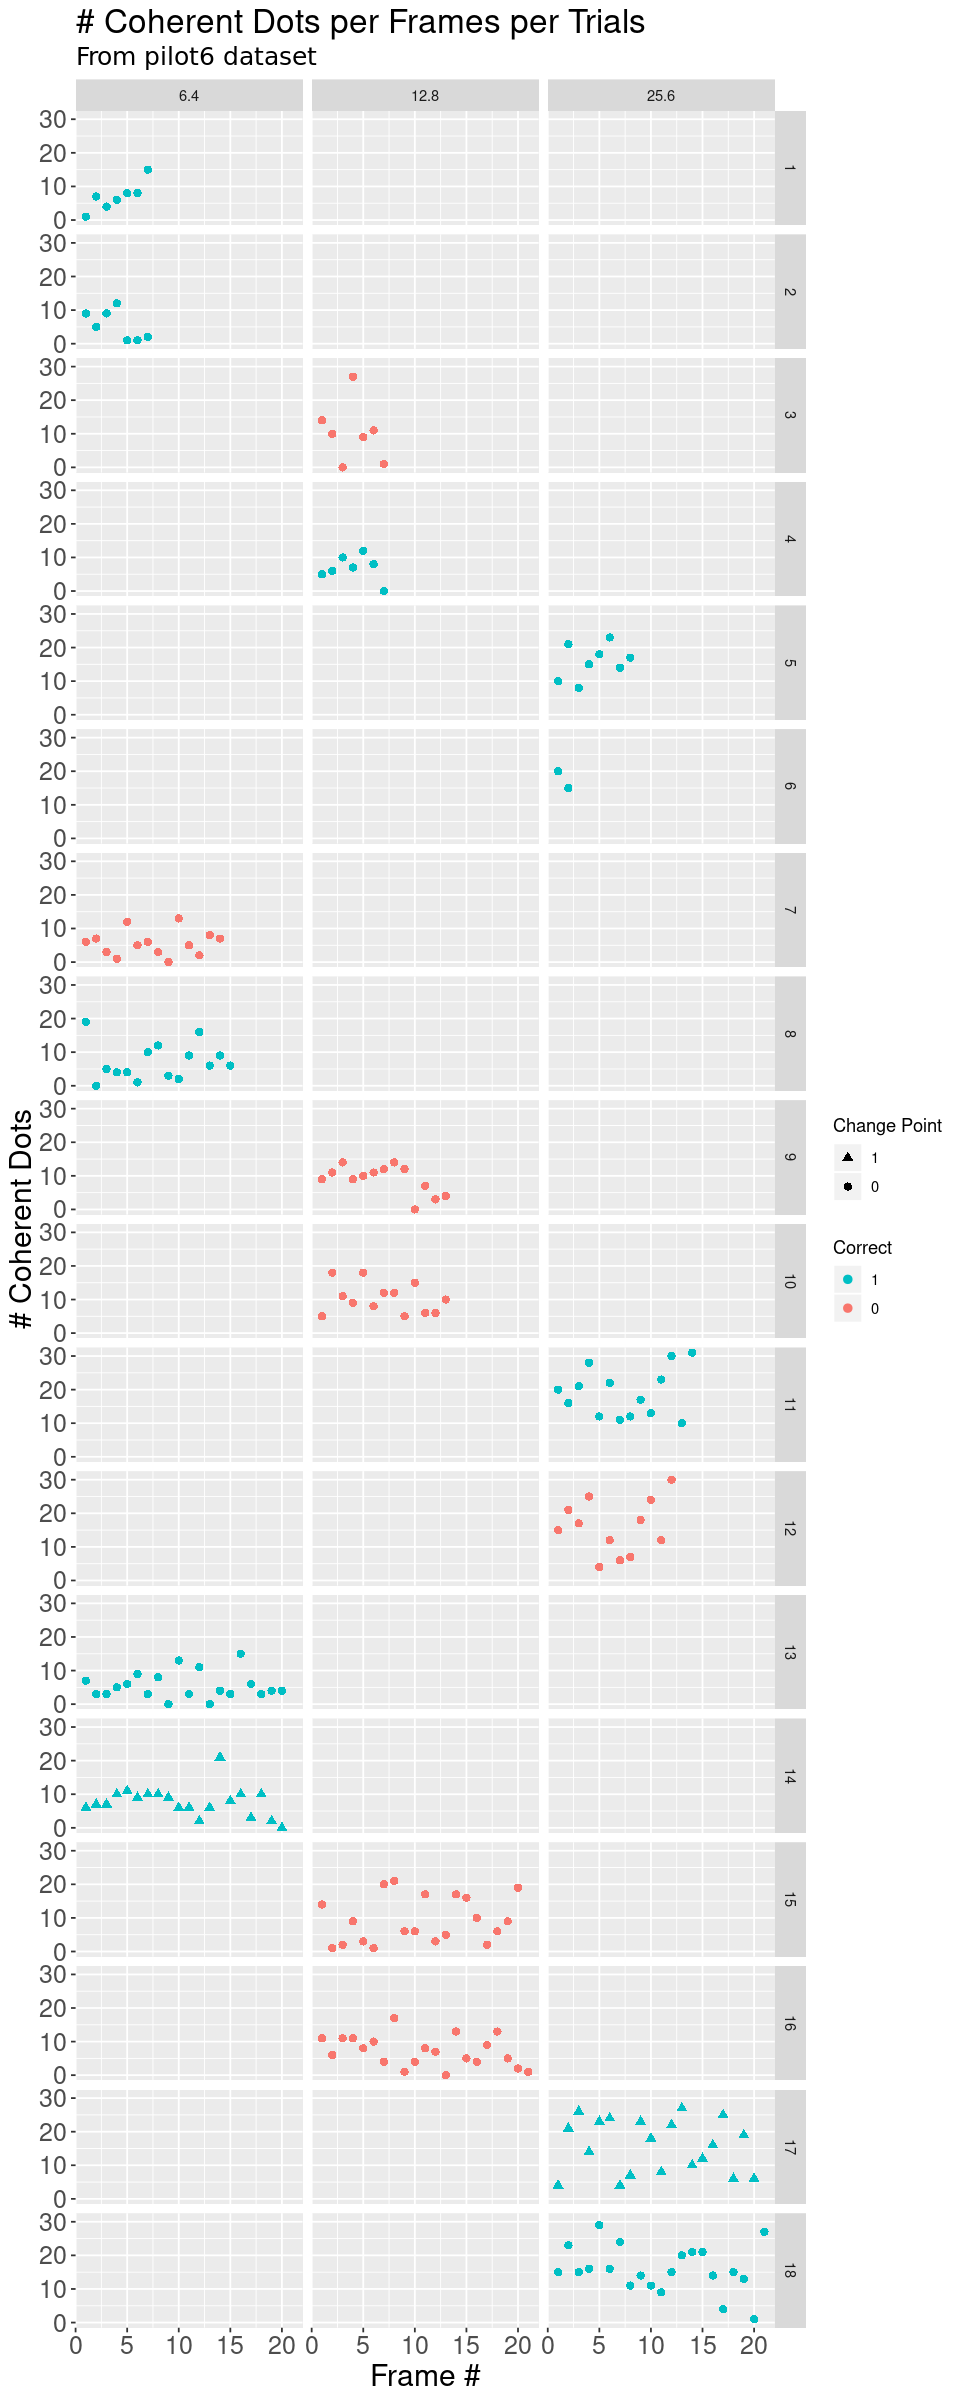

In [18]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=20)

# plot
ggplot(tb[[DOTS]][cohDots,on=c("trialCount","frameIdx")], aes(x=frameIdx, y=numCohDots)) + 
    geom_point(aes(col=factor(correct), shape=factor(presenceCP)), size=2) +
    facet_grid(trialIndex~coherence) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T), shape = guide_legend(reverse=T)) +
    labs(title="# Coherent Dots per Frames per Trials",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="# Coherent Dots",
         x="Frame #",
         color="Correct", shape="Change Point") + 
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),                                 # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text